#Time-Series Model Throwdown
ts_model_throwdown.ipynb

Compare models A and B using multiple datasets processed by the loaders in load data time-series repository.

* Builds numpy arrays using load_dataset functions and default arguments
* Builds/Trains/Evaluates two models for the selected dataset
* Displays several model evaluation figures and metrics side-by-side

See also load_dataset_demo.ipynb which is a bit more interactive.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* Leotta still requires high-RAM runtime.  Several loaders output too much info.
* Maybe compile the model in build?
* This version copied from internal repository 2/19/2023 - I need to make a number of changes to integrate with the latest loaders and remove the need to mount google drive.



# Mount Drive and get public imports
This notebook is not currently setup to run stand-alone.

In [ ]:
#mount google drive in colab session
#enter path to where the git repo was cloned
my_path = '/content/drive/My Drive/Colab Notebooks/imics_lab_repositories/load_data_time_series_dev'
my_dir = '.'

In [ ]:
import os
import shutil
from scipy import io #for loadmat, matlab conversion
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget

# Get load_data_utils from IMICS public repository

In [ ]:
def get_load_data_utils():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'load_data_utils.py'
    ffname = os.path.join(my_dir,fname)
    if (os.path.exists(ffname)):
        if verbose:
            print ("Local load_data_utils.py found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py", filename=fname)

get_load_data_utils()

In [ ]:
import load_data_utils as utils # ldu just seemed confusing!
print('My env_info: \n' + utils.get_env_info()) # using + vs , gets rid of space

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 510.47.03, 15360 MiB



#Get numpy arrays using load_dataset

In [ ]:
# Copy selected .py file into colab and import load_dataset function
# k_size is the size of the kernel used in the model, one-half of a second
# works well, actual value is based on sample freq e.g. 32Hz -> k_size = 16.
# EPOCHS are max run, training also has early stopping callback
def get_dataset(dataset):
    if (dataset == 'MobiAct_ADL'):
        full_filename = my_path+os.path.join('/HAR/MobiAct/'+'mobiact_adl_load_dataset.py')
        shutil.copy(full_filename,'mobiact_adl_load_dataset.py')
        # MobiAct uses local copy due to difficulty automatically downloading from source.
        zip_ffname = my_dir+os.path.join('/drive/MyDrive/Datasets/MobiAct_Dataset_v1.0.zip')
        shutil.copy(zip_ffname,'MobiAct_Dataset_v1.0.zip')
        from mobiact_adl_load_dataset import mobiact_adl_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = mobiact_adl_load_dataset(incl_val_group = True)
        k_size = 50
        EPOCHS = 50
        t_names = ['JOG','JUM','STD','STN','STU','WAL']
        
    elif (dataset == 'UniMiB_SHAR'):
        full_filename = my_path+ os.path.join('/HAR/UniMiB_SHAR/'+'unimib_shar_adl_load_dataset.py')
        shutil.copy(full_filename,'unimib_shar_adl_load_dataset.py')
        from unimib_shar_adl_load_dataset import unimib_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = unimib_load_dataset(incl_val_group = True)
        t_names = ['StandingUpFS','StandingUpFL','Walking','Running','GoingUpS','Jumping','GoingDownS','LyingDownFS','SittingDown']
        k_size = 50
        EPOCHS = 60
    elif (dataset == 'UCI_HAR'):
        full_filename = my_path+os.path.join('/HAR/UCI_HAR/'+'uci_har_load_dataset.py')
        shutil.copy(full_filename,'uci_har_load_dataset.py')
        from uci_har_load_dataset import uci_har_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = uci_har_load_dataset(incl_val_group = True)
        t_names = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
        k_size = 50
        EPOCHS = 120
    elif (dataset == 'TWristAR'):
        full_filename = my_path+os.path.join('/HAR/e4_wristband_Nov2019/'+'e4_load_dataset.py')
        shutil.copy(full_filename,'e4_load_dataset.py')
        from e4_load_dataset import e4_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test = e4_load_dataset(incl_val_group = True, incl_xyz_accel= True)
        t_names = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
        k_size = 16
        EPOCHS = 100
    elif (dataset == 'Leotta_2021'):
        full_filename = my_path+os.path.join('/ADL/Leotta_2021/'+'leotta_2021_load_dataset.py')
        shutil.copy(full_filename,'leotta_2021_load_dataset.py')
        from leotta_2021_load_dataset import leotta_2021_load_dataset
        x_train, y_train, x_valid, y_valid, x_test, y_test, log_info = leotta_2021_load_dataset(incl_val_group = True)
        # Note:  OTHER referenced in readme.txt was deleted during the processing,
        # and the one-hot encoding shifted everything by one, hence RELAX = 0 now
        t_names = ['RELAX','KEYBOARD_WRITING','LAPTOP','HANDWRITING',
                    'HANDWASHING','FACEWASHING','TEETHBRUSH','SWEEPING','VACUUMING',
                    'EATING','DUSTING','RUBBING','DOWNSTAIRS','WALKING',
                    'WALKING_FAST','UPSTAIRS_FAST','UPSTAIRS']
        k_size = 33
        EPOCHS = 50
    elif (dataset == 'SHL'):
        # the existing .py has been tested but not with saved IRs.
        # using a version _temp that may only work with save IRs for now.
        full_filename = my_path+os.path.join('/HAR/SHL/'+'shl_load_dataset_temp.py')
        shutil.copy(full_filename,'shl_load_dataset.py')
        from shl_load_dataset import shl_load_dataset
        print("Without saved IR3 (X, y ,sub) this will take an hour+ to run")
        x_train, y_train, x_valid, y_valid, x_test, y_test \
                             = shl_load_dataset(verbose = False,
                                                use_saved_xysub = True,
                                                incl_val_group = True,
                                                return_info_dict = False)
        t_names = ['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway']
        k_size = 17
        EPOCHS = 50
    elif (dataset == 'PSG-Audio'):
        # the mini psg-audio loader lacks full functionality
        full_filename = my_path+os.path.join('/Sleep/'+'psg_audio_mini_loader.py')
        shutil.copy(full_filename,'psg_audio_mini_loader.py')
        from psg_audio_mini_loader import psga_mini_load_dataset
        print("using PSG-Audio mini-loader")
        x_train, y_train, x_valid, y_valid, x_test, y_test = psga_mini_load_dataset(incl_val_group=True)
        t_names = ['Normal','Apnea', 'Hypopnea']
        k_size = 35
        EPOCHS = 50 
    else:
        print('ERROR: dataset unknown')
    return x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names

# This test to confirm all datasets can be loaded before running a long evaluation pass.

In [ ]:
ds_list = ["MobiAct_ADL", "UniMiB_SHAR","UCI_HAR", "TWristAR","Leotta_2021"]
ds_list = ["Leotta_2021"]
ds_list = ["SHL"]
ds_list = ["PSG-Audio"]
for i in ds_list:
    dataset = i
    print("**** Processing ", dataset, " ****")
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset(dataset)
    print(dataset)
    print(utils.tabulate_numpy_arrays({"x_train":x_train, "y_train":y_train,
                                     "x_valid":x_valid, "y_valid":y_valid,
                                     "x_test" :x_test,  "y_test":y_test}))
    print("k_size =",k_size,"(typically a half-second worth of samples or less)")
    print("Class names =",t_names)



**** Processing  PSG-Audio  ****
using PSG-Audio mini-loader
small_x_train.npy Local small_x_train.npy found, skipping download
small_y_train.npy Local small_y_train.npy found, skipping download
small_sub_train.npy Local small_sub_train.npy found, skipping download
small_x_test.npy Local small_x_test.npy found, skipping download
small_y_test.npy Local small_y_test.npy found, skipping download
Loading small arrays
PSG-Audio
array    shape             data type
-------  ----------------  -----------
x_train  (115358, 100, 3)  float32
y_train  (115358, 3)       float64
x_valid  (34858, 100, 3)   float32
y_valid  (34858, 3)        float64
x_test   (66870, 100, 3)   float32
y_test   (66870, 3)        float64
k_size = 35 (typically a half-second worth of samples or less)
Class names = ['Normal', 'Apnea', 'Hypopnea']


#Model A: LSTM model
Credit Brownlee, model example 
[here](https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/)

In [ ]:
# Model credit Jason Brownlee
# https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
modelA_desc = "LSTM, Brownlee"
def build_modelA(x_train, y_train, k_size):
    #k_size is not used for the lstm model
  #verbose, epochs, batch_size = 0, 15, 64 # original values, not set in train
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
	    layers.LSTM(100, input_shape=(n_timesteps,n_features)),
        layers.Dropout(0.5),
	    layers.Dense(100, activation='relu'),
	    layers.Dense(n_outputs, activation='softmax')
        ])
  return model
  	#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
if (False): #set to True while developing new model
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset('UCI_HAR')
    modelA = build_modelA(x_train, y_train, k_size)
    keras.utils.plot_model(modelA, 'modelA.png',show_shapes=True)
    plt.imshow(plt.imread('modelA.png'))
    

#Model B: 1D CNN model with Global Average Pooling Layer
topology and good article
[here](https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf)

In [ ]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
modelB_desc = "1 CNN with GlobalAvgPool and no MaxPool"
def build_modelB(x_train, y_train, k_size):
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]

  model = keras.Sequential(
    [
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu',input_shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=100, kernel_size=k_size, activation='relu'),
      layers.GlobalAveragePooling1D(),
      layers.Dense(n_outputs, activation='softmax')
    ])
  return model
if (False): #set to True while developing new model
    modelB = build_modelB(x_train, y_train, k_size)
    keras.utils.plot_model(modelB, 'modelB.png',show_shapes=True)

#Train the model, evaluate using validation set

In [ ]:
def train_model(model, x_train, y_train, x_valid, y_valid,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 100): # Max number run unless earlystopping callback fires
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    callback = EarlyStopping(monitor='val_loss', mode = 'min', patience=7)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        callbacks=[callback],
        validation_data=(x_valid,y_valid),
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history, model

# Run the model - predict using the test data

In [ ]:
def run_model(model,x_test):
    predictions = model.predict(x_test, verbose = 0, batch_size = 64)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    return y_pred

**** Processing  MobiAct_ADL  ****
Unzipping MobiAct Dataset
Generating filenames  JOG_acc_*.txt  from  MobiAct_Dataset/JOG/  directory
Generating filenames  JUM_acc_*.txt  from  MobiAct_Dataset/JUM/  directory
Generating filenames  STD_acc_*.txt  from  MobiAct_Dataset/STD/  directory
Generating filenames  STN_acc_*.txt  from  MobiAct_Dataset/STN/  directory
Generating filenames  STU_acc_*.txt  from  MobiAct_Dataset/STU/  directory
Generating filenames  WAL_acc_*.txt  from  MobiAct_Dataset/WAL/  directory
Epoch 1/100
131/131 [==============================] - 10s 24ms/step - loss: 0.9388 - accuracy: 0.6771 - val_loss: 0.4575 - val_accuracy: 0.8647
Epoch 2/100
131/131 [==============================] - 3s 20ms/step - loss: 0.8263 - accuracy: 0.7272 - val_loss: 0.6398 - val_accuracy: 0.8218
Epoch 3/100
131/131 [==============================] - 3s 20ms/step - loss: 0.5296 - accuracy: 0.8344 - val_loss: 0.4623 - val_accuracy: 0.8790
Epoch 4/100
131/131 [==============================] - 3

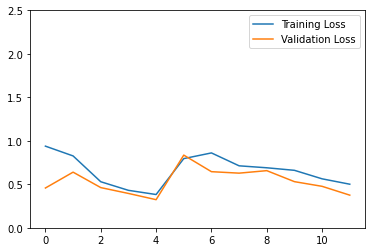

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         JOG       0.86      0.78      0.82       147
         JUM       0.85      0.90      0.87       145
         STD       1.00      1.00      1.00       425
         STN       0.00      0.00      0.00        60
         STU       0.00      0.00      0.00        60
         WAL       0.82      1.00      0.90       558

    accuracy                           0.88      1395
   macro avg       0.59      0.61      0.60      1395
weighted avg       0.81      0.88      0.84      1395



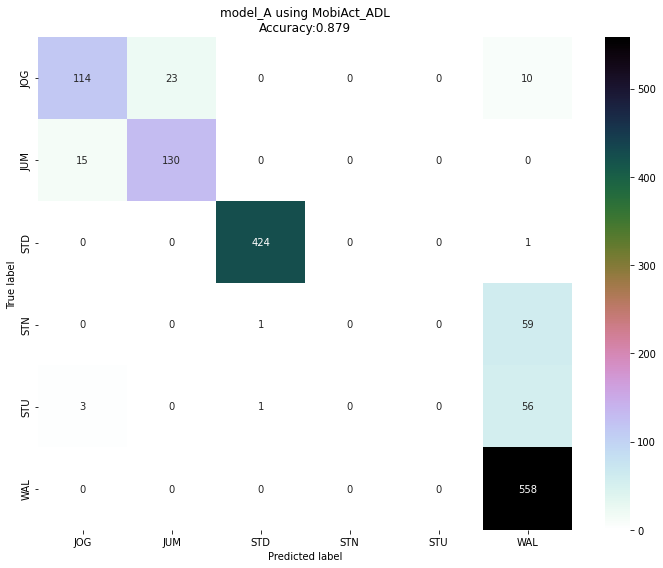

Epoch 1/100
131/131 [==============================] - 6s 12ms/step - loss: 0.6629 - accuracy: 0.8012 - val_loss: 0.1571 - val_accuracy: 0.9520
Epoch 2/100
131/131 [==============================] - 1s 9ms/step - loss: 0.1318 - accuracy: 0.9625 - val_loss: 0.0576 - val_accuracy: 0.9857
Epoch 3/100
131/131 [==============================] - 1s 9ms/step - loss: 0.0731 - accuracy: 0.9757 - val_loss: 0.0492 - val_accuracy: 0.9857
Epoch 4/100
131/131 [==============================] - 1s 9ms/step - loss: 0.0587 - accuracy: 0.9790 - val_loss: 0.0413 - val_accuracy: 0.9907
Epoch 5/100
131/131 [==============================] - 1s 9ms/step - loss: 0.0595 - accuracy: 0.9821 - val_loss: 0.0325 - val_accuracy: 0.9936
Epoch 6/100
131/131 [==============================] - 1s 9ms/step - loss: 0.0268 - accuracy: 0.9905 - val_loss: 0.0304 - val_accuracy: 0.9900
Epoch 7/100
131/131 [==============================] - 1s 10ms/step - loss: 0.0228 - accuracy: 0.9938 - val_loss: 0.0281 - val_accuracy: 0.99

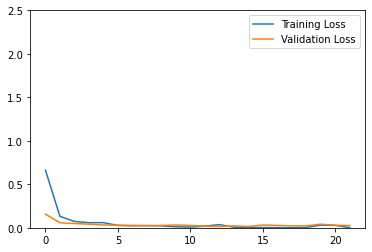

              precision    recall  f1-score   support

         JOG       0.99      0.88      0.93       147
         JUM       0.98      1.00      0.99       145
         STD       1.00      1.00      1.00       425
         STN       0.77      0.92      0.84        60
         STU       0.93      0.87      0.90        60
         WAL       0.98      0.99      0.99       558

    accuracy                           0.98      1395
   macro avg       0.94      0.94      0.94      1395
weighted avg       0.98      0.98      0.98      1395



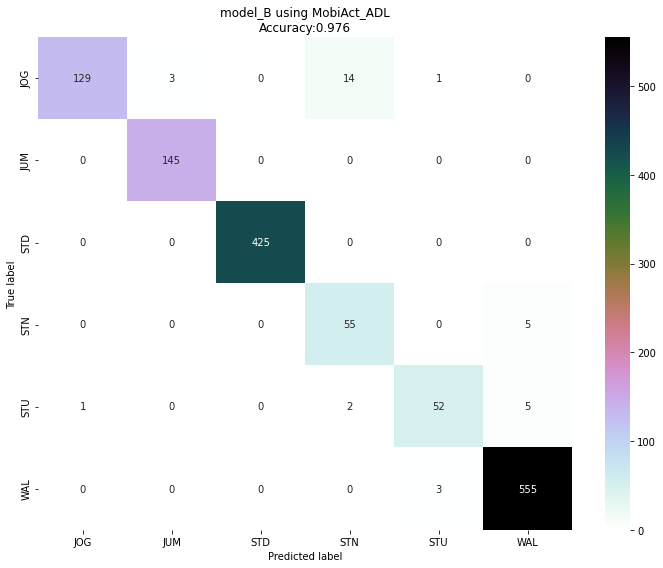

**** Processing  UniMiB_SHAR  ****
Raw data     shape        object type              data type
-----------  -----------  -----------------------  -----------
adl_data:    (7579, 453)  <class 'numpy.ndarray'>  float64
adl_labels:  (7579, 3)    <class 'numpy.ndarray'>  uint8
adl_names:   (9, 1)       <class 'numpy.ndarray'>  object
Reshaped data    shape           object type              data type
---------------  --------------  -----------------------  -----------
adl_data:        (7579, 151, 1)  <class 'numpy.ndarray'>  float64
adl_labels:      (7579, 3)       <class 'numpy.ndarray'>  uint8
adl_names:       (9, 1)          <class 'numpy.ndarray'>  object
x/y_train shape  (4601, 151, 1) (4601,)
x/y_validation shape  (1454, 151, 1) (1454,)
x/y_test shape   (1524, 151, 1) (1524,)
After one-hot encoding
x/y_train shape  (4601, 151, 1) (4601, 9)
x/y_validation shape  (1454, 151, 1) (1454, 9)
x/y_test shape   (1524, 151, 1) (1524, 9)
Epoch 1/100
144/144 [==============================] - 

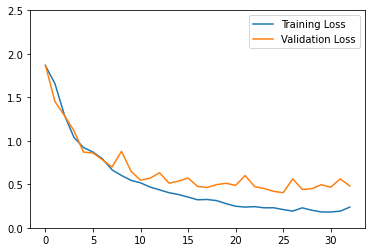

              precision    recall  f1-score   support

StandingUpFS       0.51      1.00      0.67        34
StandingUpFL       0.56      0.11      0.18        47
     Walking       0.96      0.94      0.95       344
     Running       1.00      1.00      1.00       413
    GoingUpS       0.83      0.91      0.87       184
     Jumping       1.00      0.97      0.98       146
  GoingDownS       0.96      0.99      0.98       256
 LyingDownFS       0.67      0.59      0.62        68
 SittingDown       0.65      0.62      0.63        32

    accuracy                           0.92      1524
   macro avg       0.79      0.79      0.77      1524
weighted avg       0.92      0.92      0.91      1524



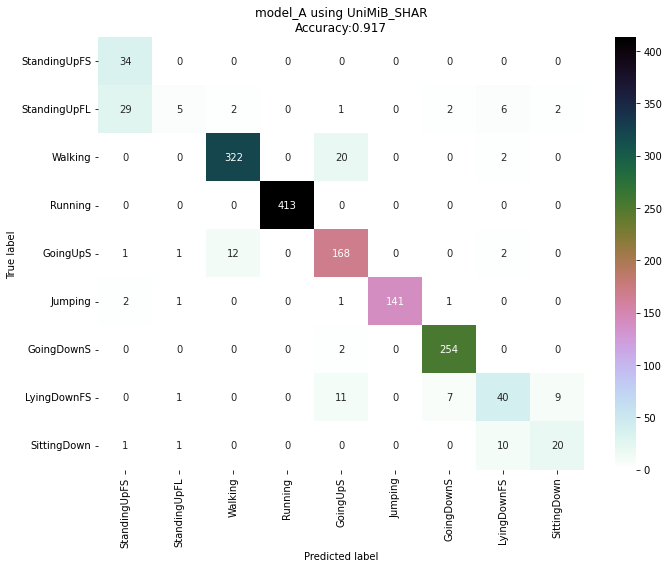

Epoch 1/100
144/144 [==============================] - 2s 8ms/step - loss: 1.1979 - accuracy: 0.6201 - val_loss: 0.9827 - val_accuracy: 0.6369
Epoch 2/100
144/144 [==============================] - 1s 4ms/step - loss: 0.7715 - accuracy: 0.7461 - val_loss: 0.7178 - val_accuracy: 0.7682
Epoch 3/100
144/144 [==============================] - 1s 4ms/step - loss: 0.5668 - accuracy: 0.8140 - val_loss: 0.5204 - val_accuracy: 0.8370
Epoch 4/100
144/144 [==============================] - 1s 4ms/step - loss: 0.4907 - accuracy: 0.8355 - val_loss: 0.4622 - val_accuracy: 0.8418
Epoch 5/100
144/144 [==============================] - 1s 4ms/step - loss: 0.4256 - accuracy: 0.8531 - val_loss: 0.5356 - val_accuracy: 0.8150
Epoch 6/100
144/144 [==============================] - 1s 4ms/step - loss: 0.3848 - accuracy: 0.8648 - val_loss: 0.5455 - val_accuracy: 0.8006
Epoch 7/100
144/144 [==============================] - 1s 4ms/step - loss: 0.3316 - accuracy: 0.8826 - val_loss: 0.4671 - val_accuracy: 0.8418

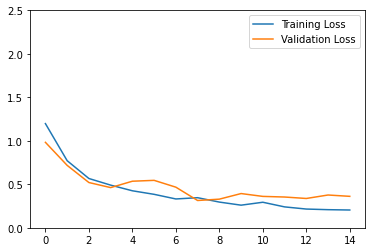

              precision    recall  f1-score   support

StandingUpFS       0.73      0.79      0.76        34
StandingUpFL       0.83      0.21      0.34        47
     Walking       0.98      0.92      0.95       344
     Running       0.97      1.00      0.98       413
    GoingUpS       0.84      0.99      0.91       184
     Jumping       1.00      0.75      0.86       146
  GoingDownS       0.89      0.98      0.93       256
 LyingDownFS       0.48      0.79      0.60        68
 SittingDown       1.00      0.06      0.12        32

    accuracy                           0.90      1524
   macro avg       0.86      0.72      0.72      1524
weighted avg       0.91      0.90      0.89      1524



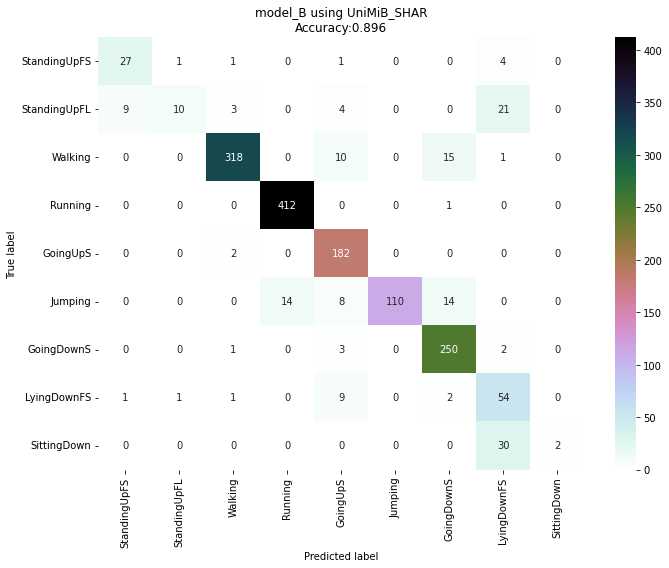

**** Processing  UCI_HAR  ****
Unzipping UCI_HAR_Dataset.zip file

The validation group is generated using sklearn stratify on train
It is not subject independent - confirm accuracy with test set
Epoch 1/100
173/173 [==============================] - 4s 13ms/step - loss: 1.3029 - accuracy: 0.3230 - val_loss: 1.1587 - val_accuracy: 0.3210
Epoch 2/100
173/173 [==============================] - 1s 8ms/step - loss: 1.1442 - accuracy: 0.3625 - val_loss: 1.1285 - val_accuracy: 0.3618
Epoch 3/100
173/173 [==============================] - 1s 8ms/step - loss: 1.0914 - accuracy: 0.3952 - val_loss: 1.0425 - val_accuracy: 0.4347
Epoch 4/100
173/173 [==============================] - 1s 8ms/step - loss: 1.1058 - accuracy: 0.3952 - val_loss: 1.0924 - val_accuracy: 0.4102
Epoch 5/100
173/173 [==============================] - 1s 8ms/step - loss: 1.1063 - accuracy: 0.3992 - val_loss: 1.0701 - val_accuracy: 0.4206
Epoch 6/100
173/173 [==============================] - 1s 8ms/step - loss: 0.9836 - accu

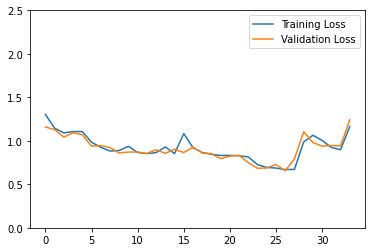

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                    precision    recall  f1-score   support

           WALKING       0.34      0.89      0.49       496
  WALKING_UPSTAIRS       0.00      0.00      0.00       471
WALKING_DOWNSTAIRS       0.53      0.37      0.44       420
           SITTING       0.31      0.86      0.46       491
          STANDING       0.00      0.00      0.00       532
            LAYING       0.00      0.00      0.00       537

          accuracy                           0.35      2947
         macro avg       0.20      0.35      0.23      2947
      weighted avg       0.18      0.35      0.22      2947



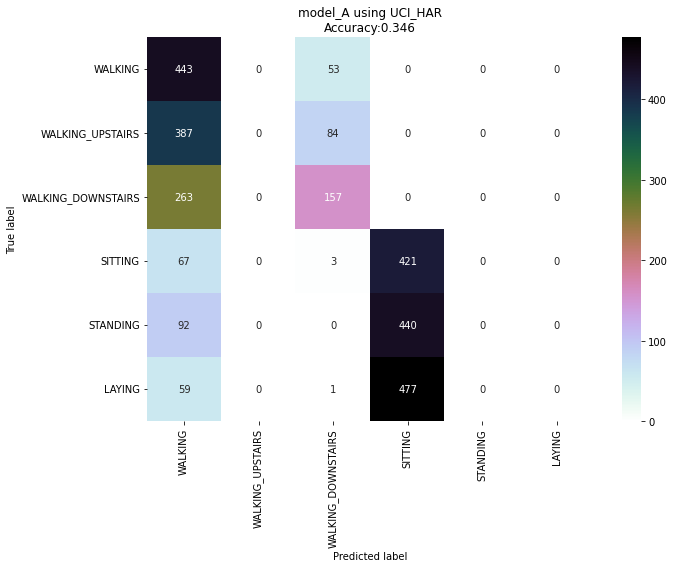

Epoch 1/100
173/173 [==============================] - 2s 7ms/step - loss: 0.8923 - accuracy: 0.5689 - val_loss: 0.6467 - val_accuracy: 0.6300
Epoch 2/100
173/173 [==============================] - 1s 4ms/step - loss: 0.6081 - accuracy: 0.6817 - val_loss: 0.5815 - val_accuracy: 0.7220
Epoch 3/100
173/173 [==============================] - 1s 4ms/step - loss: 0.5221 - accuracy: 0.7543 - val_loss: 0.5321 - val_accuracy: 0.7595
Epoch 4/100
173/173 [==============================] - 1s 4ms/step - loss: 0.4543 - accuracy: 0.7873 - val_loss: 0.4435 - val_accuracy: 0.7954
Epoch 5/100
173/173 [==============================] - 1s 4ms/step - loss: 0.4103 - accuracy: 0.8123 - val_loss: 0.4404 - val_accuracy: 0.7933
Epoch 6/100
173/173 [==============================] - 1s 4ms/step - loss: 0.3834 - accuracy: 0.8215 - val_loss: 0.4231 - val_accuracy: 0.8221
Epoch 7/100
173/173 [==============================] - 1s 4ms/step - loss: 0.3695 - accuracy: 0.8346 - val_loss: 0.3951 - val_accuracy: 0.8275

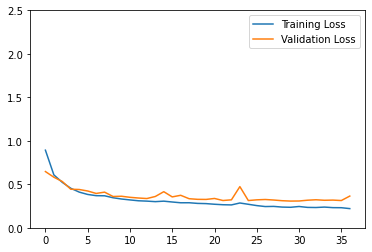

                    precision    recall  f1-score   support

           WALKING       1.00      0.77      0.87       496
  WALKING_UPSTAIRS       0.85      0.96      0.90       471
WALKING_DOWNSTAIRS       0.90      1.00      0.95       420
           SITTING       0.64      0.62      0.63       491
          STANDING       0.71      0.83      0.76       532
            LAYING       0.90      0.79      0.84       537

          accuracy                           0.82      2947
         macro avg       0.83      0.83      0.82      2947
      weighted avg       0.83      0.82      0.82      2947



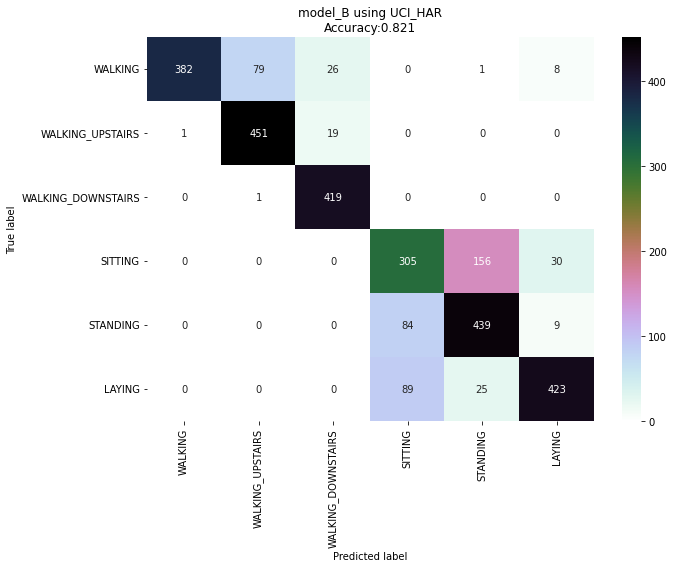

**** Processing  TWristAR  ****
Unzipping TWristAR file in local directory
Processing  ./TWristAR/sub1/1574621345_A01F11.zip
Unzipping TWristAR file in local directory
./temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 18:49:05
File end time   =  Sun, 24 Nov 2019 18:58:11
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574621375.17 Sun, 24 Nov 2019 18:49:35
1 1574621774.22 Sun, 24 Nov 2019 18:56:14
Label Counts - # samples before sliding window
 Upstairs      6208
Downstairs    5889
Undefined     5405
Name: label, dtype: int64
Processing  ./TWristAR/sub1/1574622389_A01F11.zip
Unzipping TWristAR file in local directory
./temp/ACC.csv Sample frequency =  32.0  Hz
File start time =  Sun, 24 Nov 2019 19:06:29
File end time   =  Sun, 24 Nov 2019 19:15:03
Tag info (button presses) from tags.csv
    UTC_time          Local Time
0 1574622432.21 Sun, 24 Nov 2019 19:07:12
1 1574622822.72 Sun, 24 Nov 2019 19:13:42
Label Counts - # samples b

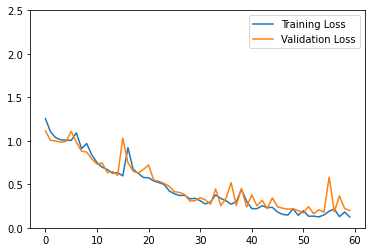

              precision    recall  f1-score   support

  Downstairs       0.93      0.73      0.82       173
     Jogging       0.95      1.00      0.97       173
     Sitting       1.00      0.11      0.20       171
    Standing       0.99      0.87      0.93       186
    Upstairs       0.64      0.87      0.74       198
     Walking       0.39      0.66      0.49       190

    accuracy                           0.71      1091
   macro avg       0.82      0.71      0.69      1091
weighted avg       0.81      0.71      0.69      1091



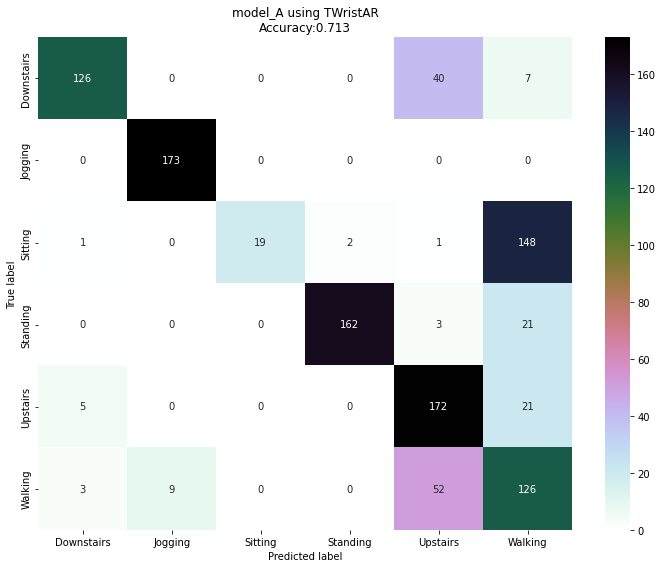

Epoch 1/100
52/52 [==============================] - 1s 12ms/step - loss: 0.8666 - accuracy: 0.6689 - val_loss: 0.5046 - val_accuracy: 0.8462
Epoch 2/100
52/52 [==============================] - 0s 4ms/step - loss: 0.4622 - accuracy: 0.8260 - val_loss: 0.3940 - val_accuracy: 0.8269
Epoch 3/100
52/52 [==============================] - 0s 4ms/step - loss: 0.3529 - accuracy: 0.8850 - val_loss: 0.3428 - val_accuracy: 0.9014
Epoch 4/100
52/52 [==============================] - 0s 4ms/step - loss: 0.3104 - accuracy: 0.9079 - val_loss: 0.2856 - val_accuracy: 0.9471
Epoch 5/100
52/52 [==============================] - 0s 4ms/step - loss: 0.2573 - accuracy: 0.9187 - val_loss: 0.2456 - val_accuracy: 0.9471
Epoch 6/100
52/52 [==============================] - 0s 4ms/step - loss: 0.2229 - accuracy: 0.9205 - val_loss: 0.2771 - val_accuracy: 0.9014
Epoch 7/100
52/52 [==============================] - 0s 4ms/step - loss: 0.2104 - accuracy: 0.9410 - val_loss: 0.2446 - val_accuracy: 0.9375
Epoch 8/100


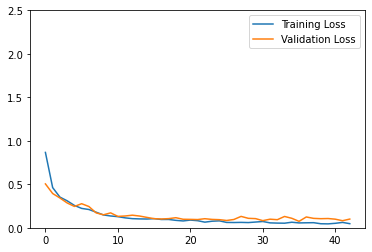

              precision    recall  f1-score   support

  Downstairs       0.42      0.67      0.52       173
     Jogging       0.93      0.23      0.37       173
     Sitting       1.00      0.47      0.64       171
    Standing       0.99      0.62      0.76       186
    Upstairs       0.79      0.80      0.79       198
     Walking       0.49      0.96      0.65       190

    accuracy                           0.64      1091
   macro avg       0.77      0.63      0.62      1091
weighted avg       0.77      0.64      0.63      1091



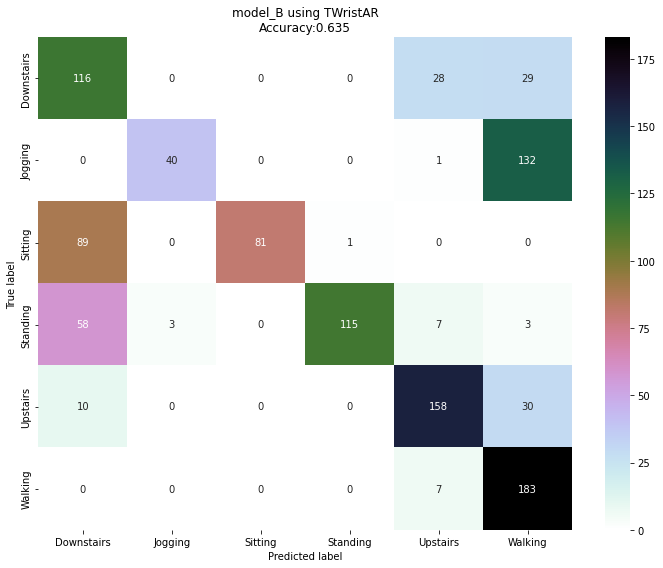

**** Processing  Leotta_2021  ****
Unzipping Leotta 2021 dataset
Using source file /content/drive/My Drive/Datasets/ADL_Leotta_2021.zip
Processing subject number 1
Processing:  /content/dataset/ankle/ankle_X_01.csv /content/dataset/ankle/ankle_Y_01.csv
Processing:  /content/dataset/hip/hip_X_01.csv /content/dataset/hip/hip_Y_01.csv
Processing:  /content/dataset/wrist/wrist_X_01.csv /content/dataset/wrist/wrist_Y_01.csv
Resampling to 10ms Original # rows =  780800 New # rows =  305000
confirmed label and sub match - dropping from ankle and hip
Using 12 features ['ankle_accel_x', 'ankle_accel_y', 'ankle_accel_z', 'ankle_accel_ttl', 'hip_accel_x', 'hip_accel_y', 'hip_accel_z', 'hip_accel_ttl', 'wrist_accel_x', 'wrist_accel_y', 'wrist_accel_z', 'wrist_accel_ttl']
No NaN entries found
Processing subject number 2
Processing:  /content/dataset/ankle/ankle_X_02.csv /content/dataset/ankle/ankle_Y_02.csv
Processing:  /content/dataset/hip/hip_X_02.csv /content/dataset/hip/hip_Y_02.csv
Processing:

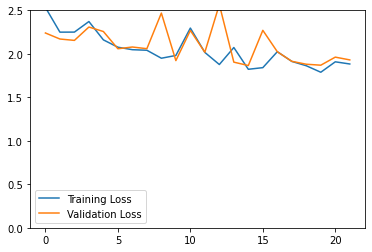

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

           RELAX       0.23      1.00      0.38        78
KEYBOARD_WRITING       0.00      0.00      0.00        80
          LAPTOP       0.12      0.01      0.02        78
     HANDWRITING       0.09      0.01      0.02        79
     HANDWASHING       0.12      0.55      0.20        78
     FACEWASHING       0.00      0.00      0.00        78
      TEETHBRUSH       0.00      0.00      0.00        78
        SWEEPING       0.33      0.01      0.02        78
       VACUUMING       0.00      0.00      0.00        79
          EATING       0.08      0.04      0.05        79
         DUSTING       0.00      0.00      0.00        79
         RUBBING       0.35      0.84      0.49        79
      DOWNSTAIRS       0.00      0.00      0.00        47
         WALKING       0.31      0.18      0.23        76
    WALKING_FAST       0.43      1.00      0.61        72
   UPSTAIRS_FAST       0.00      0.00      0.00        19
        UPSTA

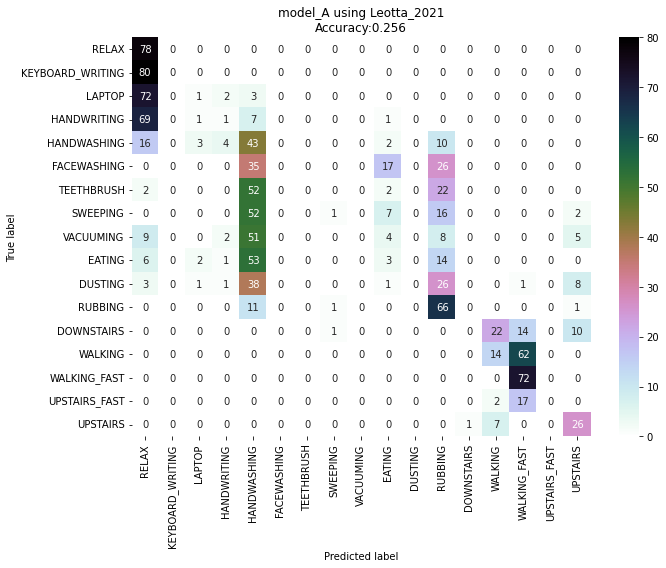

Epoch 1/100
75/75 [==============================] - 1s 10ms/step - loss: 2.1190 - accuracy: 0.2457 - val_loss: 1.9200 - val_accuracy: 0.3751
Epoch 2/100
75/75 [==============================] - 1s 7ms/step - loss: 1.3465 - accuracy: 0.5508 - val_loss: 1.5500 - val_accuracy: 0.4606
Epoch 3/100
75/75 [==============================] - 1s 7ms/step - loss: 0.9934 - accuracy: 0.6485 - val_loss: 1.5301 - val_accuracy: 0.4699
Epoch 4/100
75/75 [==============================] - 1s 7ms/step - loss: 0.8474 - accuracy: 0.6941 - val_loss: 1.4361 - val_accuracy: 0.5182
Epoch 5/100
75/75 [==============================] - 1s 7ms/step - loss: 0.7713 - accuracy: 0.7172 - val_loss: 1.3422 - val_accuracy: 0.5114
Epoch 6/100
75/75 [==============================] - 1s 7ms/step - loss: 0.7019 - accuracy: 0.7345 - val_loss: 1.3947 - val_accuracy: 0.5461
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 0.6501 - accuracy: 0.7577 - val_loss: 1.3961 - val_accuracy: 0.5428
Epoch 8/100


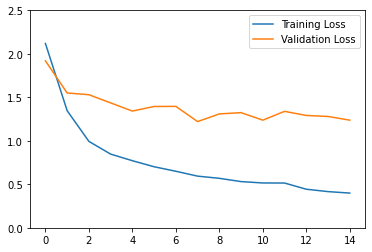

                  precision    recall  f1-score   support

           RELAX       0.69      0.12      0.20        78
KEYBOARD_WRITING       0.41      0.50      0.45        80
          LAPTOP       0.28      0.47      0.36        78
     HANDWRITING       0.90      0.96      0.93        79
     HANDWASHING       0.62      0.41      0.49        78
     FACEWASHING       0.54      0.50      0.52        78
      TEETHBRUSH       0.39      0.49      0.43        78
        SWEEPING       0.67      0.13      0.22        78
       VACUUMING       0.49      0.85      0.62        79
          EATING       0.80      0.84      0.81        79
         DUSTING       0.71      0.89      0.79        79
         RUBBING       0.98      0.81      0.89        79
      DOWNSTAIRS       0.89      1.00      0.94        47
         WALKING       0.98      0.70      0.82        76
    WALKING_FAST       0.73      0.81      0.77        72
   UPSTAIRS_FAST       0.53      0.84      0.65        19
        UPSTA

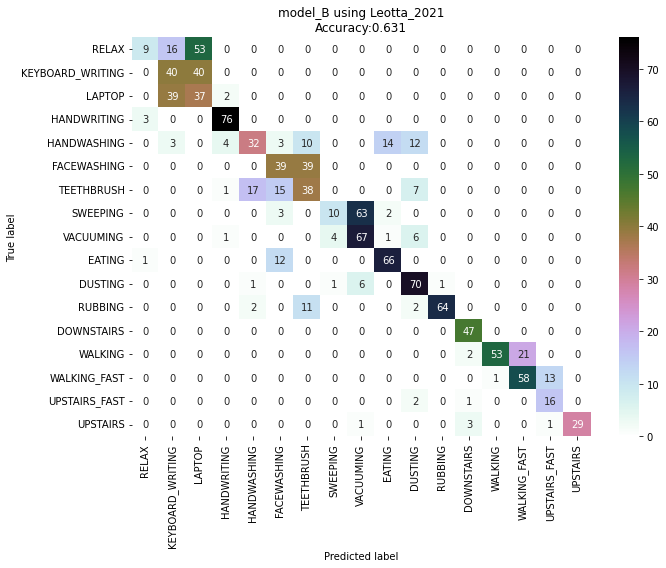

**** Processing  SHL  ****
Without saved IR3 (X, y ,sub) this will take an hour+ to run
shl_load_dataset: use_saved_xysub = True
Epoch 1/100
379/379 [==============================] - 6s 12ms/step - loss: 0.7016 - accuracy: 0.7391 - val_loss: 4.5083 - val_accuracy: 0.2782
Epoch 2/100
379/379 [==============================] - 4s 10ms/step - loss: 0.4936 - accuracy: 0.7994 - val_loss: 5.2225 - val_accuracy: 0.2211
Epoch 3/100
379/379 [==============================] - 4s 10ms/step - loss: 0.4668 - accuracy: 0.8085 - val_loss: 5.4578 - val_accuracy: 0.2712
Epoch 4/100
379/379 [==============================] - 4s 10ms/step - loss: 0.4098 - accuracy: 0.8314 - val_loss: 6.1047 - val_accuracy: 0.2472
Epoch 5/100
379/379 [==============================] - 4s 10ms/step - loss: 0.4266 - accuracy: 0.8202 - val_loss: 6.2410 - val_accuracy: 0.2333
Epoch 6/100
379/379 [==============================] - 4s 10ms/step - loss: 0.4198 - accuracy: 0.8230 - val_loss: 6.2236 - val_accuracy: 0.2822
Epoch 7

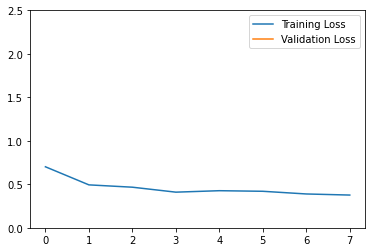

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Still       0.07      0.07      0.07      3523
     Walking       0.73      0.45      0.56      2246
         Run       0.00      0.00      0.00       371
        Bike       0.00      0.00      0.00       766
         Car       0.23      0.99      0.37      1007
         Bus       0.22      0.50      0.30       991
       Train       0.00      0.00      0.00      2743
      Subway       0.00      0.00      0.00      2213

    accuracy                           0.20     13860
   macro avg       0.16      0.25      0.16     13860
weighted avg       0.17      0.20      0.16     13860



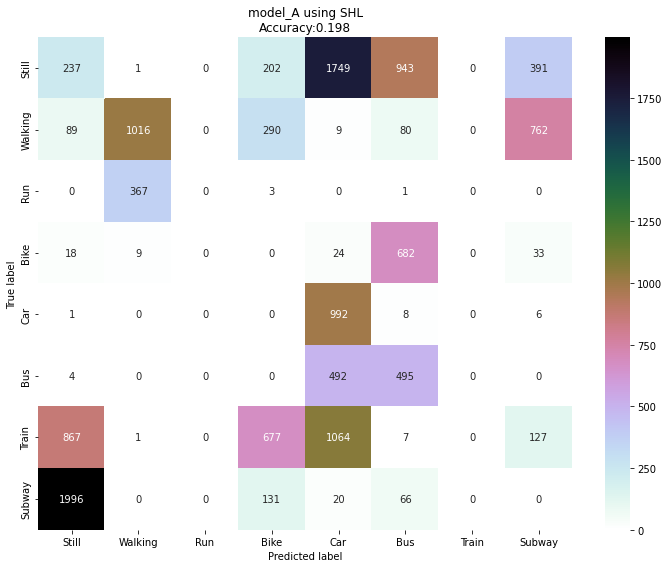

Epoch 1/100
379/379 [==============================] - 4s 7ms/step - loss: 0.5208 - accuracy: 0.7907 - val_loss: 10.5188 - val_accuracy: 0.1457
Epoch 2/100
379/379 [==============================] - 2s 6ms/step - loss: 0.4157 - accuracy: 0.8289 - val_loss: 10.1581 - val_accuracy: 0.2379
Epoch 3/100
379/379 [==============================] - 2s 6ms/step - loss: 0.3718 - accuracy: 0.8465 - val_loss: 12.7329 - val_accuracy: 0.2211
Epoch 4/100
379/379 [==============================] - 2s 7ms/step - loss: 0.3541 - accuracy: 0.8476 - val_loss: 13.6809 - val_accuracy: 0.1802
Epoch 5/100
379/379 [==============================] - 2s 6ms/step - loss: 0.3327 - accuracy: 0.8607 - val_loss: 15.9479 - val_accuracy: 0.2009
Epoch 6/100
379/379 [==============================] - 2s 6ms/step - loss: 0.3300 - accuracy: 0.8634 - val_loss: 16.1685 - val_accuracy: 0.2560
Epoch 7/100
379/379 [==============================] - 2s 6ms/step - loss: 0.3146 - accuracy: 0.8697 - val_loss: 18.3098 - val_accuracy:

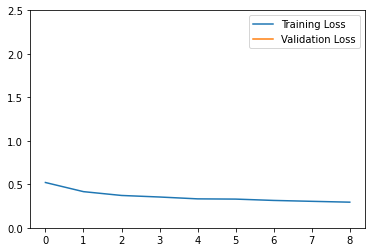

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Still       0.10      0.12      0.11      3523
     Walking       0.81      0.73      0.77      2246
         Run       0.00      0.00      0.00       371
        Bike       0.01      0.00      0.00       766
         Car       0.17      0.99      0.29      1007
         Bus       0.00      0.00      0.00       991
       Train       0.00      0.00      0.00      2743
      Subway       0.00      0.00      0.00      2213

    accuracy                           0.22     13860
   macro avg       0.14      0.23      0.15     13860
weighted avg       0.17      0.22      0.17     13860



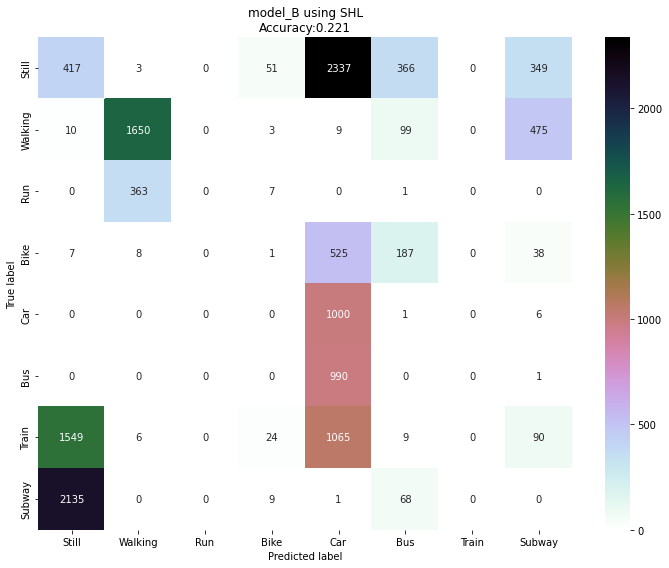

**** Processing  PSG-Audio  ****
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
using PSG-Audio mini-loader
small_x_train.npy copying
small_y_train.npy copying
small_sub_train.npy copying
small_x_test.npy copying
small_y_test.npy copying
Loading small arrays
Epoch 1/100
3605/3605 [==============================] - 27s 7ms/step - loss: 0.6679 - accuracy: 0.7429 - val_loss: 0.6462 - val_accuracy: 0.7522
Epoch 2/100
3605/3605 [==============================] - 26s 7ms/step - loss: 0.6386 - accuracy: 0.7544 - val_loss: 0.6463 - val_accuracy: 0.7551
Epoch 3/100
3605/3605 [==============================] - 25s 7ms/step - loss: 0.6217 - accuracy: 0.7610 - val_loss: 0.6269 - val_accuracy: 0.7607
Epoch 4/100
3605/3605 [==============================] - 26s 7ms/step - loss: 0.6116 - accuracy: 0.7657 - val_loss: 0.6238 - val_accuracy: 0.7679
Epoch 5/100
3605/3605 [==============================] - 26s 7ms/step - los

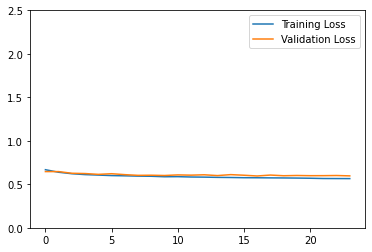

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Normal       0.94      0.83      0.88     55172
       Apnea       0.46      0.75      0.57     11289
    Hypopnea       0.00      0.00      0.00       409

    accuracy                           0.81     66870
   macro avg       0.47      0.52      0.48     66870
weighted avg       0.85      0.81      0.82     66870



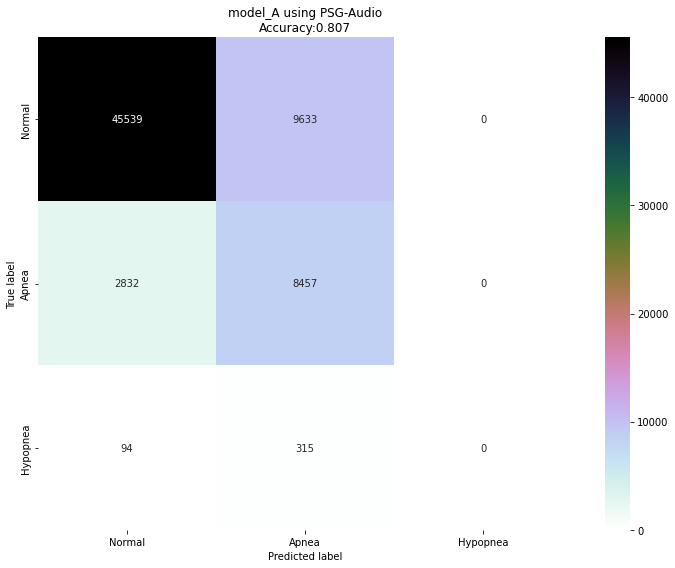

Epoch 1/100
3605/3605 [==============================] - 16s 4ms/step - loss: 0.6834 - accuracy: 0.7387 - val_loss: 0.6432 - val_accuracy: 0.7575
Epoch 2/100
3605/3605 [==============================] - 16s 4ms/step - loss: 0.6393 - accuracy: 0.7559 - val_loss: 0.6421 - val_accuracy: 0.7593
Epoch 3/100
3605/3605 [==============================] - 15s 4ms/step - loss: 0.6307 - accuracy: 0.7593 - val_loss: 0.6214 - val_accuracy: 0.7663
Epoch 4/100
3605/3605 [==============================] - 16s 4ms/step - loss: 0.6246 - accuracy: 0.7599 - val_loss: 0.6147 - val_accuracy: 0.7680
Epoch 5/100
3605/3605 [==============================] - 16s 4ms/step - loss: 0.6196 - accuracy: 0.7632 - val_loss: 0.6297 - val_accuracy: 0.7612
Epoch 6/100
3605/3605 [==============================] - 16s 4ms/step - loss: 0.6164 - accuracy: 0.7646 - val_loss: 0.6219 - val_accuracy: 0.7554
Epoch 7/100
3605/3605 [==============================] - 15s 4ms/step - loss: 0.6132 - accuracy: 0.7655 - val_loss: 0.6264 -

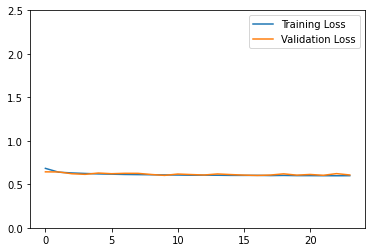

              precision    recall  f1-score   support

      Normal       0.93      0.85      0.89     55172
       Apnea       0.48      0.72      0.58     11289
    Hypopnea       0.00      0.00      0.00       409

    accuracy                           0.82     66870
   macro avg       0.47      0.52      0.49     66870
weighted avg       0.85      0.82      0.83     66870



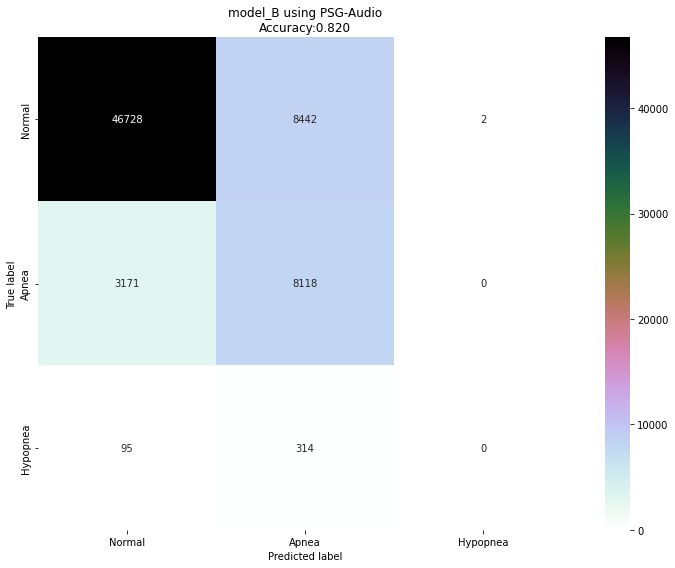

Running: MobiAct_ADL, UniMiB_SHAR, UCI_HAR, TWristAR, Leotta_2021, SHL, PSG-Audio
Model A: [0.879 0.917 0.346 0.713 0.256 0.198 0.807] mean:0.588
Model B: [0.976 0.896 0.821 0.635 0.631 0.221 0.82 ] mean:0.714


In [ ]:
#TODO Leotta returns log_info - need to add that to the others
ds_list = ["MobiAct_ADL", "UniMiB_SHAR","UCI_HAR", "TWristAR","Leotta_2021", "SHL","PSG-Audio"]
log_out = "Running: " + str(', '.join(ds_list))
modelA_acc = []
modelB_acc = []
model = None # just to keep from running erroneous pass
for i in ds_list:
    dataset = i
    print("**** Processing ", dataset, " ****")
    x_train, y_train, x_valid, y_valid, x_test, y_test, k_size, EPOCHS, t_names = get_dataset(dataset)

    model_names = ['model_A','model_B']
    model = None # just to keep from running erroneous pass
    #acknowledgement to @MikeHordecki https://stackoverflow.com/questions/522563/accessing-the-index-in-for-loops
    for idx, curr_mname in enumerate(model_names):   
        if (idx == 0):
            model = build_modelA(x_train, y_train, k_size)
        elif (idx == 1):
            model = build_modelB(x_train, y_train, k_size)
        else:
            print ("Something went wrong!")
            model = None # just to keep from running erroneous pass
        plot_name = curr_mname +'_'+ dataset + '.png'
        keras.utils.plot_model(model, plot_name, show_shapes=True)
        history, model = train_model(model, x_train, y_train, x_valid, y_valid)
        #show final training loss
        print(curr_mname, "evaluate using", dataset)
        print("Final Validation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.ylim([0,2.5]) #set limit - 1.2 has been a good value experimentally
        plt.legend()
        plt.show()
        y_pred = run_model(model, x_test)
        y_test_act = np.argmax(y_test, axis=-1) # undo one-hot encoding
        acc = accuracy_score(y_test_act, y_pred)
        if (idx == 0):
            modelA_acc.append(acc)
        if (idx == 1):
            modelB_acc.append(acc)
        print(classification_report(y_test_act, y_pred, target_names=t_names))
        cm = confusion_matrix(y_test_act, y_pred)
        cm_df = pd.DataFrame(cm,
                            index = t_names, 
                            columns = t_names)
        cm_height = 10 # was 1.2*len(t_names)/2
        cm_width = 8 # was len(t_names)/2)
        fig = plt.figure(figsize=(cm_height,cm_width)) # num classes => size
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
        plt.title(curr_mname +' using '+dataset+'\nAccuracy:{0:.3f}'.format(accuracy_score(y_test_act, y_pred)))
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout() # keeps labels from being cutoff when saving as pdf
        cmplot_name = curr_mname  +'_'+ dataset + '_cm.png'
        plt.savefig(cmplot_name, dpi = 300) 
        plt.show()
modelA_results = 'Model A: '+(np.array2string(np.asarray(modelA_acc), precision = 3))
modelA_results += ' mean:'+(np.array2string(np.mean(modelA_acc), precision = 3))
modelB_results = 'Model B: '+(np.array2string(np.asarray(modelB_acc), precision = 3))
modelB_results += ' mean:'+(np.array2string(np.mean(modelB_acc), precision = 3))
log_out += '\n' + modelA_results + '\n' + modelB_results
print(log_out)

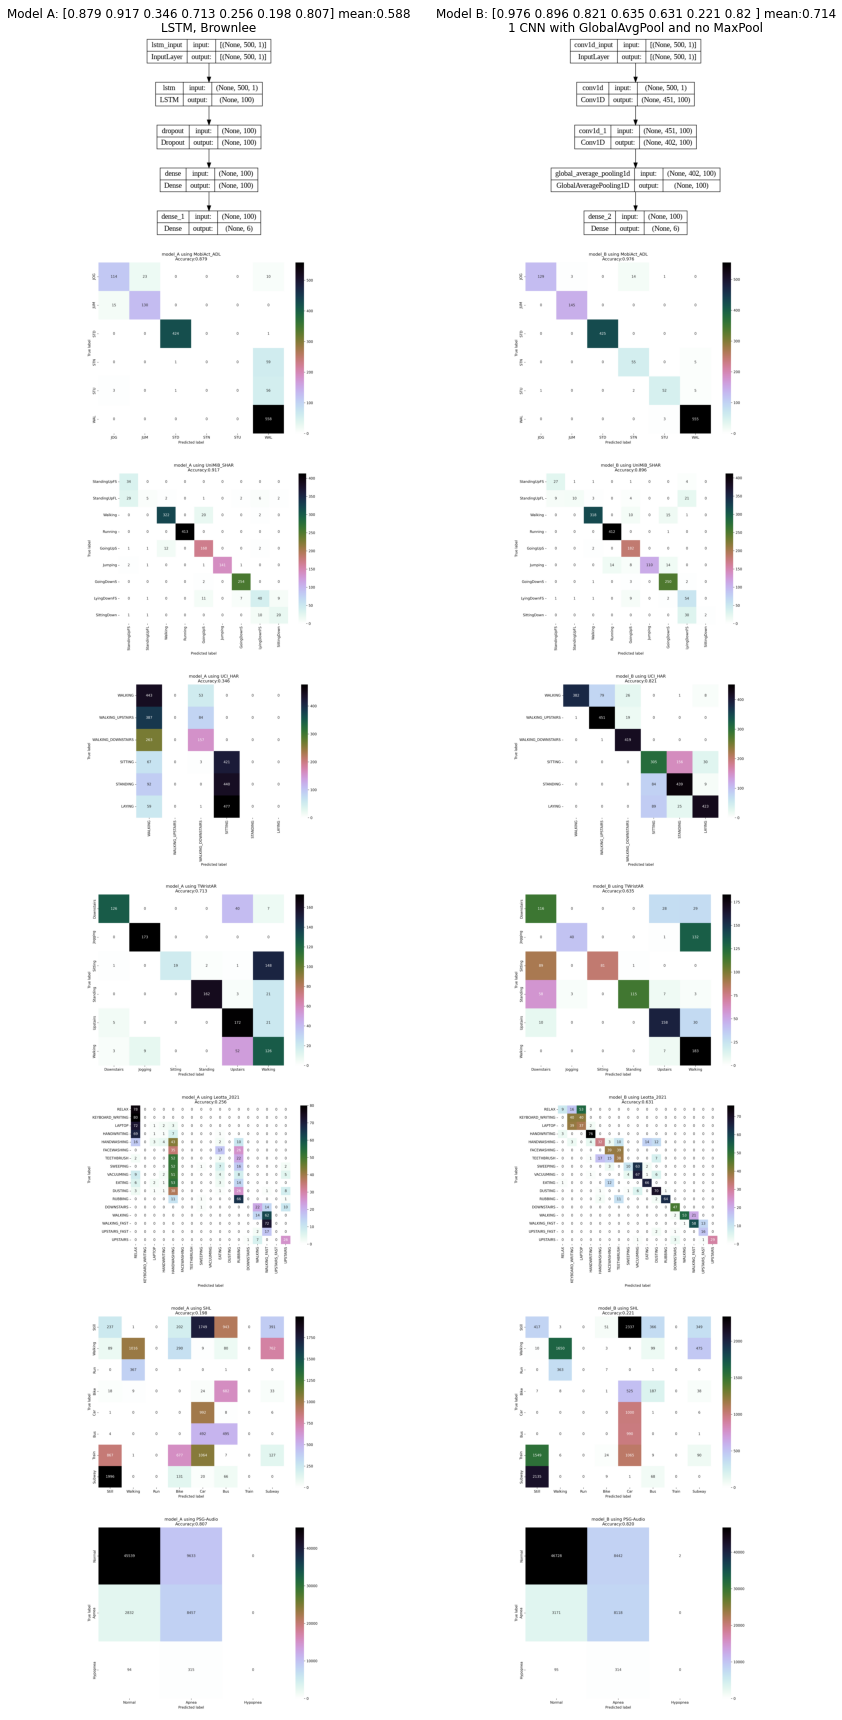

In [ ]:
#plot side by side
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
#spacing needs to be adjusted
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
rows = 8
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols)#, figsize = (40,10))
fig.set_size_inches(12,24)
for i in range(rows):
    for j in range(cols):
        axs[i, j].set_axis_off()
axs[0, 0].set_title(modelA_results+'\n'+modelA_desc)
axs[0, 1].set_title(modelB_results+'\n'+modelB_desc)
axs[0, 0].imshow(plt.imread('model_A_MobiAct_ADL.png'))
axs[0, 1].imshow(plt.imread('model_B_MobiAct_ADL.png'))
axs[1, 0].imshow(plt.imread('model_A_MobiAct_ADL_cm.png'))
axs[1, 1].imshow(plt.imread('model_B_MobiAct_ADL_cm.png'))
axs[2, 0].imshow(plt.imread('model_A_UniMiB_SHAR_cm.png'))
axs[2, 1].imshow(plt.imread('model_B_UniMiB_SHAR_cm.png'))
axs[3, 0].imshow(plt.imread('model_A_UCI_HAR_cm.png'))
axs[3, 1].imshow(plt.imread('model_B_UCI_HAR_cm.png'))
axs[4, 0].imshow(plt.imread('model_A_TWristAR_cm.png'))
axs[4, 1].imshow(plt.imread('model_B_TWristAR_cm.png'))
axs[5, 0].imshow(plt.imread('model_A_Leotta_2021_cm.png'))
axs[5, 1].imshow(plt.imread('model_B_Leotta_2021_cm.png'))
axs[6, 0].imshow(plt.imread('model_A_SHL_cm.png'))
axs[6, 1].imshow(plt.imread('model_B_SHL_cm.png'))
axs[7, 0].imshow(plt.imread('model_A_PSG-Audio_cm.png'))
axs[7, 1].imshow(plt.imread('model_B_PSG-Audio_cm.png'))

plt.tight_layout()
plt.savefig('throwdown.png', dpi = 300) # don't forget to download!


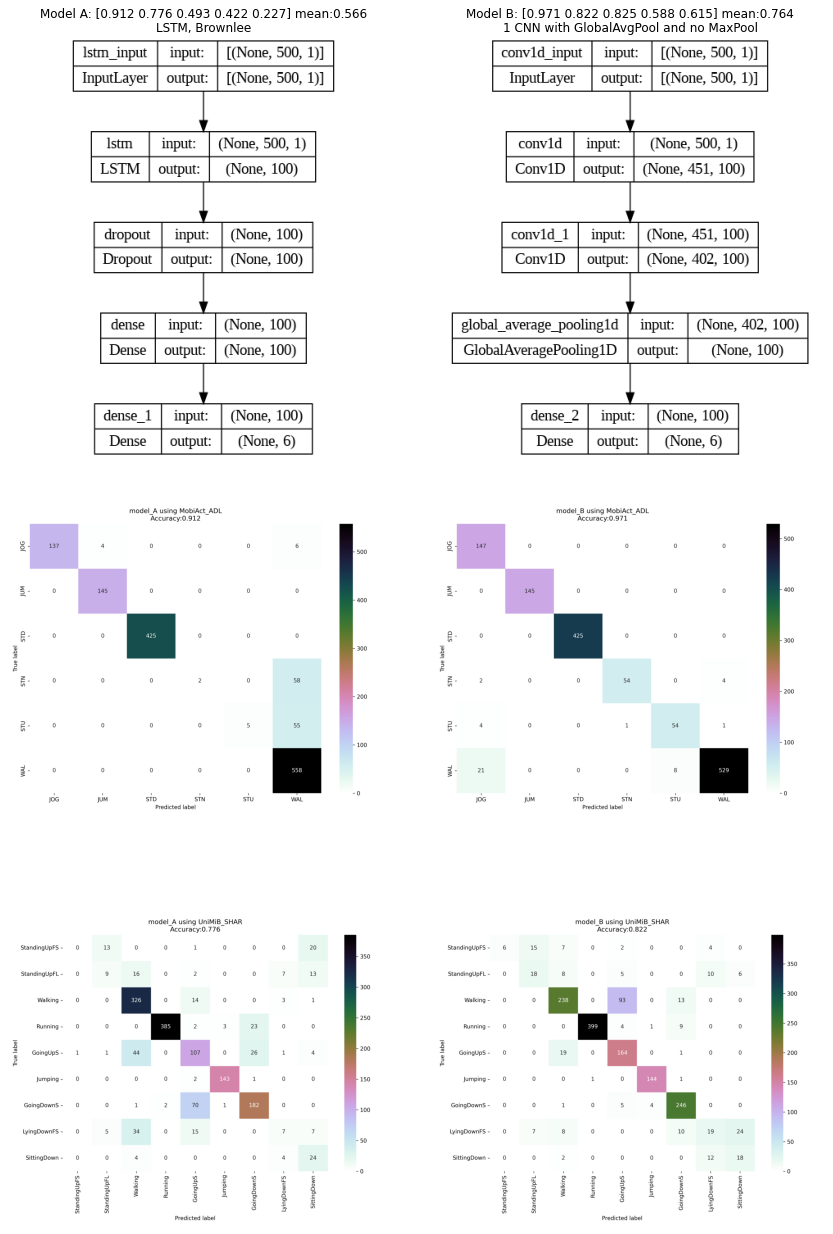

In [ ]:
#plot side by side only 2 confusion matrics
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
#spacing needs to be adjusted
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
rows = 3
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols)#, figsize = (40,10))
fig.set_size_inches(12,18)
for i in range(rows):
    for j in range(cols):
        axs[i, j].set_axis_off()
axs[0, 0].set_title(modelA_results+'\n'+modelA_desc)
axs[0, 1].set_title(modelB_results+'\n'+modelB_desc)
axs[0, 0].imshow(plt.imread('model_A_MobiAct_ADL.png'))
axs[0, 1].imshow(plt.imread('model_B_MobiAct_ADL.png'))
axs[1, 0].imshow(plt.imread('model_A_MobiAct_ADL_cm.png'))
axs[1, 1].imshow(plt.imread('model_B_MobiAct_ADL_cm.png'))
axs[2, 0].imshow(plt.imread('model_A_UniMiB_SHAR_cm.png'))
axs[2, 1].imshow(plt.imread('model_B_UniMiB_SHAR_cm.png'))

plt.tight_layout()
plt.savefig('throwdown2.png', dpi = 300) # don't forget to download!
